In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
class MultiArmedBanditEnv:
    def __init__(self, num_arms, means=None, stds=None, bias=0):
        self.num_arms = num_arms
        if means is None or stds is None:
            self.means = np.random.uniform(0, 1, size=self.num_arms) * 30 + bias
            self.stds = np.random.uniform(0, 1, size=self.num_arms) * 10
        else:
            self.means = means
            self.stds = stds
        #print("self.means", self.means, "self.stds", self.stds)

    def pull_arm(self, arm_index):
        return np.random.normal(self.means[arm_index], self.stds[arm_index])

class EpsilonGreedyAgent:
    def __init__(self, epsilon, num_arms):
        self.epsilon = epsilon
        self.num_arms = num_arms
        self.rewards = np.zeros(num_arms)
        self.counts = np.zeros(num_arms)
        self.current_arm = 0  # Начинаем с руки 0
        self.visited_arms = False  # Flag to track if all arms have been visited

    def select_arm(self, verbose=False):
        if not self.visited_arms:
            arm = self.current_arm
            self.current_arm = (self.current_arm + 1) % self.num_arms  # Переходим к следующей руке
            #self.counts[arm] += 1
            if np.sum(self.counts > 0) >= len(self.counts) - 1:
                self.visited_arms = True
            if verbose:
                print("Перебираю руки, arm = ", arm)
            return arm
        elif np.random.rand() < self.epsilon:
            arm = np.random.randint(self.num_arms)
            if verbose:
                print("Разведывательный шаг, arm = ", arm)
            return arm
        else:
            if verbose:
                print(f"Средние реворды: {np.round(self.rewards / self.counts, 1)}, arm = {np.argmax(self.rewards / self.counts)}")
            return np.argmax(self.rewards / self.counts)

    def update(self, arm_index, reward):
        self.rewards[arm_index] += reward
        self.counts[arm_index] += 1


class PolicyIterationAgent:
    def __init__(self, alpha, num_arms, base=None):
        self.alpha = alpha
        self.num_arms = num_arms
        self.H = np.zeros(num_arms)  # Предпочтительность действий
        self.probabilities = np.ones(num_arms) / num_arms  # Начальная стратегия
        self.rewards = np.zeros(num_arms)
        self.counts = np.zeros(num_arms)
        self.mean_reward = 0  # Среднее вознаграждение
        self.base = base  # Базовое вознаграждение (если используется)

    def select_arm(self, verbose=False):
        arm = np.random.choice(self.num_arms, p=self.probabilities)
        if verbose:
            print("Эксплуатационный шаг, arm =", arm)
        return arm

    def update(self, arm_index, reward, verbose=False):
        self.rewards[arm_index] += reward
        self.counts[arm_index] += 1
        self.mean_reward = np.sum(self.rewards) / np.sum(self.counts)

        # Обновление предпочтительности действий
        if self.base is not None:
            self.H[arm_index] += self.alpha * (reward - self.base) * (1 - self.probabilities[arm_index])
            for a in range(self.num_arms):
                if a != arm_index:
                    self.H[a] -= self.alpha * (reward - self.base) * self.probabilities[a]
        else:
            self.H[arm_index] += self.alpha * (reward - self.mean_reward) * (1 - self.probabilities[arm_index])
            for a in range(self.num_arms):
                if a != arm_index:
                    self.H[a] -= self.alpha * (reward - self.mean_reward) * self.probabilities[a]

        # Обновление стратегии
        self.probabilities = np.exp(self.H) / np.sum(np.exp(self.H))

        if verbose:
            print(f"Средние реворды: {np.round(self.rewards / self.counts, 1)}")
            print(f"Стратегия: {np.round(self.probabilities, 2)}")


class IntervalAgent:
    def __init__(self, inverval_coef, num_arms):
        self.inverval_coef = inverval_coef
        self.num_arms = num_arms
        self.rewards = np.zeros(num_arms)
        self.counts = np.zeros(num_arms)
        self.current_arm = 0  # Начинаем с руки 0
        self.visited_arms = False  # Flag to track if all arms have been visited
        self.rewards_dict = {}
        self.rewards_std = np.zeros(num_arms)

    def select_arm(self, verbose=False):
        if not self.visited_arms:
            arm = self.current_arm
            self.current_arm = (self.current_arm + 1) % self.num_arms  # Переходим к следующей руке
            #self.counts[arm] += 1
            if np.sum(self.counts > 2) >= len(self.counts) - 1:
                self.visited_arms = True
            if verbose:
                print("Перебираю руки, arm = ", arm)
            return arm
        else:
            rewards_avg = self.rewards / self.counts
            interval_widths = self.inverval_coef * self.rewards_std / np.sqrt(self.counts)
            if verbose:
                print(f"Средние реворды: {np.round(rewards_avg, 1)}, stds {np.round(interval_widths, 1)}, arm = {np.argmax(rewards_avg + interval_widths)}")
            return np.argmax(rewards_avg + interval_widths)

    def update(self, arm_index, reward):
        self.rewards[arm_index] += reward
        self.counts[arm_index] += 1
        if arm_index in self.rewards_dict:
            self.rewards_dict[arm_index].append(reward)
        else:
            self.rewards_dict[arm_index] = [reward]
        self.rewards_std[arm_index] = np.std(self.rewards_dict[arm_index][-10:])

class NoiseAgent:
    def __init__(self, noise_coef, num_arms):
        self.noise_coef = noise_coef
        self.num_arms = num_arms
        self.rewards = np.zeros(num_arms)
        self.counts = np.zeros(num_arms)
        self.current_arm = 0  # Начинаем с руки 0
        self.visited_arms = False  # Flag to track if all arms have been visited

    def select_arm(self, verbose=False):
        if not self.visited_arms:
            arm = self.current_arm
            self.current_arm = (self.current_arm + 1) % self.num_arms  # Переходим к следующей руке
            #self.counts[arm] += 1
            if np.sum(self.counts > 0) >= len(self.counts) - 1:
                self.visited_arms = True
            if verbose:
                print("Перебираю руки, arm = ", arm)
            return arm
        else:
            rewards_avg = self.rewards / self.counts
            noise = np.random.normal(rewards_avg.shape) * np.std(rewards_avg) * self.noise_coef
            if verbose:
                print(f"Средние реворды: {np.round(rewards_avg, 1)}, noise {noise}, arm = {np.argmax(rewards_avg + noise)}")
            return np.argmax(rewards_avg + noise)

    def update(self, arm_index, reward):
        self.rewards[arm_index] += reward
        self.counts[arm_index] += 1
        

def run_experiment(num_trials, num_interactions, epsilon, verbose=False, bias=0):
    agent = EpsilonGreedyAgent(epsilon, num_arms)
    rewards = np.zeros(num_interactions)

    for trial in range(num_trials):
        env = MultiArmedBanditEnv(num_arms, bias)

        for i in range(num_interactions):
            arm = agent.select_arm(verbose)
            reward = env.pull_arm(arm)
            agent.update(arm, reward)
            rewards[i] += reward

    return rewards / num_trials

def run_experiment_simple(num_trials, num_interactions, epsilon, verbose=False):
    agent = EpsilonGreedyAgent(epsilon, num_arms)
    rewards = np.zeros(num_interactions)

    for trial in range(num_trials):
        env = MultiArmedBanditEnv(num_arms)
        env.means[0] = 4
        env.stds[0] = 4
        env.means[1] = 2
        env.stds[1] = 0
        env.means[2] = 2
        env.stds[2] = 2
        print('env.means', env.means, 'env.stds', env.stds)

        for i in range(num_interactions):
            arm = agent.select_arm(verbose)
            reward = env.pull_arm(arm)
            agent.update(arm, reward)
            rewards[i] += reward
            if verbose:
                print("reward", reward)

    return rewards / num_trials

def run_experiment_gamma(num_trials, num_interactions, epsilon, gamma, verbose=False, bias=0):
    agent = EpsilonGreedyAgent(epsilon, num_arms)
    rewards = np.zeros(num_interactions)

    for trial in range(num_trials):
        env = MultiArmedBanditEnv(num_arms, bias)

        for i in range(num_interactions):
            arm = agent.select_arm(verbose)
            agent.epsilon *= gamma
            reward = env.pull_arm(arm)
            agent.update(arm, reward)
            rewards[i] += reward
            if verbose:
                print("reward", reward)
    return rewards / num_trials

def run_experiment_interval(num_trials, num_interactions, interval_coef, verbose=False, bias=0):
    agent = IntervalAgent(interval_coef, num_arms)
    rewards = np.zeros(num_interactions)
    for trial in range(num_trials):
        env = MultiArmedBanditEnv(num_arms, bias)

        for i in range(num_interactions):
            arm = agent.select_arm(verbose)
            reward = env.pull_arm(arm)
            agent.update(arm, reward)
            rewards[i] += reward
            if verbose:
                print("reward", reward)

    return rewards / num_trials

def run_experiment_noise(num_trials, num_interactions, noise_coef, verbose=False, bias=0):
    agent = NoiseAgent(noise_coef, num_arms)
    rewards = np.zeros(num_interactions)
    for trial in range(num_trials):
        env = MultiArmedBanditEnv(num_arms, bias)

        for i in range(num_interactions):
            arm = agent.select_arm(verbose)
            reward = env.pull_arm(arm)
            agent.update(arm, reward)
            rewards[i] += reward
            if verbose:
                print("reward", reward)

    return rewards / num_trials

def run_experiment_policy_iteration(num_trials, num_interactions, alpha, base, verbose=False, bias=0):
    agent = PolicyIterationAgent(alpha, num_arms, base)
    rewards = np.zeros(num_interactions)

    for trial in range(num_trials):
        env = MultiArmedBanditEnv(num_arms, bias)

        for i in range(num_interactions):
            arm = agent.select_arm(verbose)
            reward = env.pull_arm(arm)
            agent.update(arm, reward)
            rewards[i] += reward

    return rewards / num_trials

In [7]:
def rollavg_cumsum(a,n):
    'numpy.cumsum'
    assert n%2==1
    cumsum_vec = np.cumsum(np.insert(a, 0, 0)) 
    return (cumsum_vec[n:] - cumsum_vec[:-n]) / n

In [5]:
num_arms = 5
num_trials = 100
num_interactions = 50000
epsilon = 0.1

rewards = run_experiment(num_trials, num_interactions, epsilon)
    
plt.plot(rollavg_cumsum(rewards, 21))
plt.xlabel("Interaction")
plt.ylabel("Average Reward")
plt.title(f"Epsilon-Greedy Agent Performance (epsilon={epsilon})")
plt.show()

KeyboardInterrupt: 

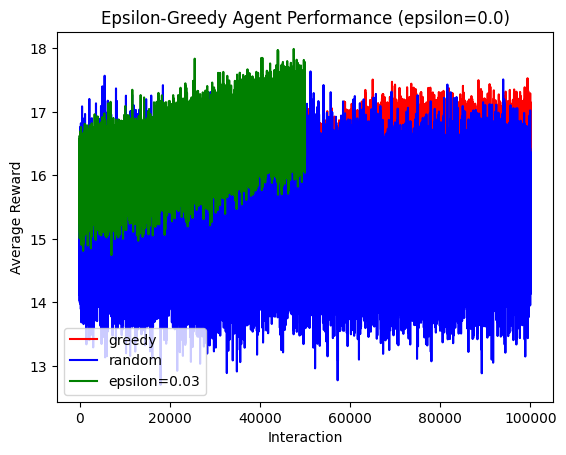

In [126]:
num_arms = 10
num_trials = 300
num_interactions = 100000
epsilon = 0.

rewards_greedy = run_experiment(num_trials, num_interactions, 0, False)
rewards_random = run_experiment(num_trials, num_interactions, 1, False)
rewards_eps_g3 = run_experiment(num_trials, num_interactions, 0.03, False)
rewards_eps_g1 = run_experiment(num_trials, num_interactions, 0.01, False)
rewards_eps_g10 = run_experiment(num_trials, num_interactions, 0.1, False)
rewards_eps_g5 = run_experiment(num_trials, num_interactions, 0.05, False)
    
plt.plot(rewards_greedy, label="greedy", color='red')
plt.plot(rewards_random, label="random", color='blue')
plt.plot(rewards_eps_g, label="epsilon=0.03", color='green')
plt.legend()
plt.xlabel("Interaction")
plt.ylabel("Average Reward")
plt.title(f"Epsilon-Greedy Agent Performance (epsilon={epsilon})")
plt.show()

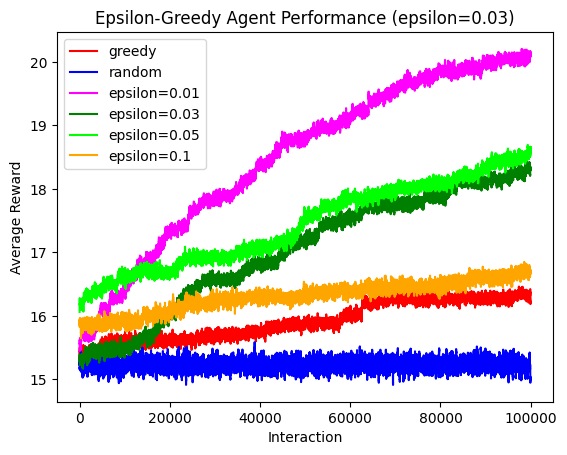

In [127]:
plt.plot(rollavg_cumsum(rewards_greedy, 51), label="greedy", color='red')
plt.plot(rollavg_cumsum(rewards_random, 51), label="random", color='blue')
plt.plot(rollavg_cumsum(rewards_eps_g1, 51), label="epsilon=0.01", color='magenta')
plt.plot(rollavg_cumsum(rewards_eps_g3, 51), label="epsilon=0.03", color='green')
plt.plot(rollavg_cumsum(rewards_eps_g5, 51), label="epsilon=0.05", color='lime')
plt.plot(rollavg_cumsum(rewards_eps_g10, 51), label="epsilon=0.1", color='orange')
plt.legend()
plt.xlabel("Interaction")
plt.ylabel("Average Reward")
plt.title(f"Epsilon-Greedy Agent Performance")
plt.show()

1
2
3
4
5
6
7
8
9
10


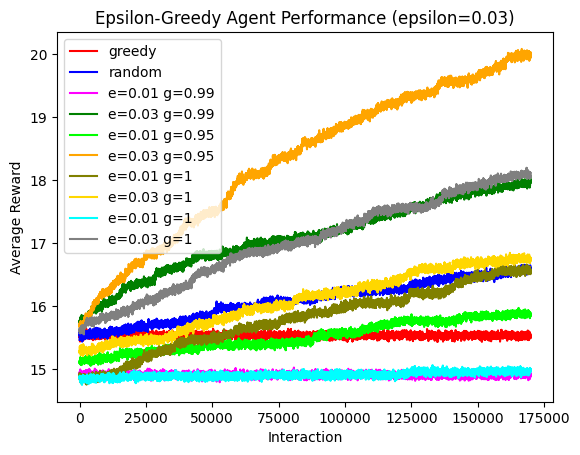

In [164]:
#Эксперименты с гаммой
num_arms = 10
num_trials = 600
num_interactions = 170000
epsilon = 0.

rewards_greedy = run_experiment_gamma(num_trials, num_interactions, 0, False)
print(1)
rewards_random = run_experiment_gamma(num_trials, num_interactions, 1, False)
print(2)
rewards_eps_g3_99 = run_experiment_gamma(num_trials, num_interactions, 0.03, 0.99, False)
print(3)
rewards_eps_g1_99 = run_experiment_gamma(num_trials, num_interactions, 0.01, 0.99, False)
print(4)
rewards_eps_g3_95 = run_experiment_gamma(num_trials, num_interactions, 0.03, 0.95, False)
print(5)
rewards_eps_g1_95 = run_experiment_gamma(num_trials, num_interactions, 0.01, 0.95, False)
print(6)
rewards_eps_g3_1 = run_experiment_gamma(num_trials, num_interactions, 0.03, 1, False)
print(7)
rewards_eps_g1_1 = run_experiment_gamma(num_trials, num_interactions, 0.01, 1, False)
print(8)
rewards_eps_g3_999 = run_experiment_gamma(num_trials, num_interactions, 0.03, 0.999, False)
print(9)
rewards_eps_g1_999 = run_experiment_gamma(num_trials, num_interactions, 0.01, 0.999, False)
print(10)
    
plt.plot(rollavg_cumsum(rewards_greedy, 71), label="greedy", color='red')
plt.plot(rollavg_cumsum(rewards_random, 71), label="random", color='blue')
plt.plot(rollavg_cumsum(rewards_eps_g1_99, 71), label="e=0.01 g=0.99", color='magenta')
plt.plot(rollavg_cumsum(rewards_eps_g3_99, 71), label="e=0.03 g=0.99", color='green')
plt.plot(rollavg_cumsum(rewards_eps_g1_95, 71), label="e=0.01 g=0.95", color='lime')
plt.plot(rollavg_cumsum(rewards_eps_g3_95, 71), label="e=0.03 g=0.95", color='orange')
plt.plot(rollavg_cumsum(rewards_eps_g1_1, 71), label="e=0.01 g=1", color='olive')
plt.plot(rollavg_cumsum(rewards_eps_g3_1, 71), label="e=0.03 g=1", color='gold')
plt.plot(rollavg_cumsum(rewards_eps_g1_999, 71), label="e=0.01 g=1", color='cyan')
plt.plot(rollavg_cumsum(rewards_eps_g3_999, 71), label="e=0.03 g=1", color='grey')
plt.legend()
plt.xlabel("Interaction")
plt.ylabel("Average Reward")
plt.title(f"Эксперименты с гаммой")
plt.show()

1
2
3
4
5
6
7


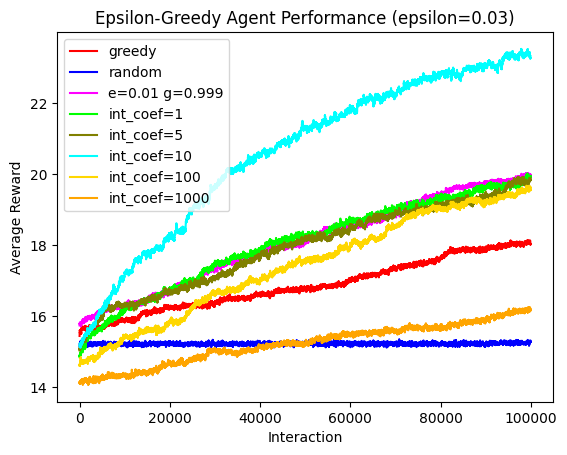

In [163]:
#Интервальная оценка
num_arms = 10
num_trials = 500
num_interactions = 100000

rewards_greedy = run_experiment_gamma(num_trials, num_interactions, 0, False)
print(1)
rewards_random = run_experiment_gamma(num_trials, num_interactions, 1, False)
print(2)
rewards_eps_g1_999 = run_experiment_gamma(num_trials, num_interactions, 0.01, 0.999, False)
print(3)
rewards_int_1 = run_experiment_interval(num_trials, num_interactions, interval_coef=1., verbose=False)
print(4)
rewards_int_1000 = run_experiment_interval(num_trials, num_interactions, interval_coef=1000., verbose=False)
print(5)
rewards_int_5 = run_experiment_interval(num_trials, num_interactions, interval_coef=5., verbose=False)
print(6)
rewards_int_100 = run_experiment_interval(num_trials, num_interactions, interval_coef=100, verbose=False)
print(7)
rewards_int_10 = run_experiment_interval(num_trials, num_interactions, interval_coef=10., verbose=False)
    
plt.plot(rollavg_cumsum(rewards_greedy, 71), label="greedy", color='red')
plt.plot(rollavg_cumsum(rewards_random, 71), label="random", color='blue')
plt.plot(rollavg_cumsum(rewards_eps_g1_999, 71), label="e=0.01 g=0.999", color='magenta')
plt.plot(rollavg_cumsum(rewards_int_1, 71), label="int_coef=1", color='lime')
plt.plot(rollavg_cumsum(rewards_int_5, 71), label="int_coef=5", color='olive')
plt.plot(rollavg_cumsum(rewards_int_10, 71), label="int_coef=10", color='cyan')
plt.plot(rollavg_cumsum(rewards_int_100, 71), label="int_coef=100", color='gold')
plt.plot(rollavg_cumsum(rewards_int_1000, 71), label="int_coef=1000", color='orange')
plt.legend()
plt.xlabel("Interaction")
plt.ylabel("Average Reward")
plt.title(f"Интервальная оценка")
plt.show()

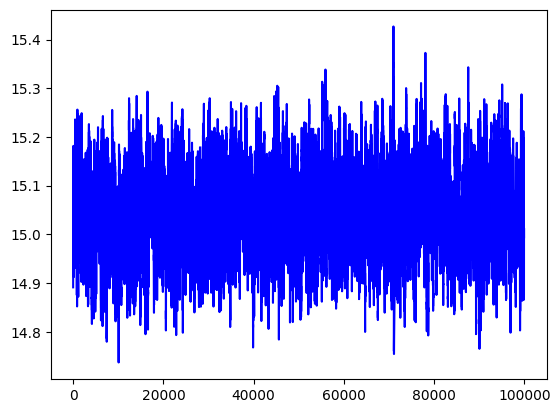

2
1
3
4
5
6


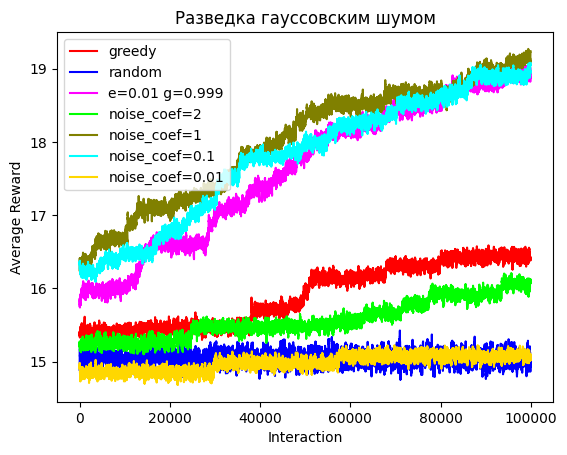

CPU times: user 1h 7min 55s, sys: 3min 9s, total: 1h 11min 4s
Wall time: 1h 8min 4s


In [9]:
%%time
#Разведка через гауссов шум
num_arms = 10
num_trials = 200
num_interactions = 100000

rewards_random = run_experiment(num_trials, num_interactions, 1, False)
plt.plot(rollavg_cumsum(rewards_random, 71), label="random", color='blue')
plt.show()
print(2)
rewards_greedy = run_experiment(num_trials, num_interactions, 0, False)
print(1)

rewards_eps_g1_999 = run_experiment_gamma(num_trials, num_interactions, 0.01, 0.999, False)
print(3)
rewards_noise_1 = run_experiment_noise(num_trials, num_interactions, 1, verbose=False)
print(4)
rewards_noise_01 = run_experiment_noise(num_trials, num_interactions, 0.1, verbose=False)
print(5)
rewards_noise_2 = run_experiment_noise(num_trials, num_interactions, 2, verbose=False)
print(6)
rewards_noise_001 = run_experiment_noise(num_trials, num_interactions, 0.01, verbose=False)

    
plt.plot(rollavg_cumsum(rewards_greedy, 71), label="greedy", color='red')
plt.plot(rollavg_cumsum(rewards_random, 71), label="random", color='blue')
plt.plot(rollavg_cumsum(rewards_eps_g1_999, 71), label="e=0.01 g=0.999", color='magenta')
#plt.plot(rollavg_cumsum(rewards_noise_10, 71), label="noise_coef=10", color='green')
plt.plot(rollavg_cumsum(rewards_noise_2, 71), label="noise_coef=2", color='lime')
plt.plot(rollavg_cumsum(rewards_noise_1, 71), label="noise_coef=1", color='olive')
plt.plot(rollavg_cumsum(rewards_noise_01, 71), label="noise_coef=0.1", color='cyan')
plt.plot(rollavg_cumsum(rewards_noise_001, 71), label="noise_coef=0.01", color='gold')
plt.legend()
plt.xlabel("Interaction")
plt.ylabel("Average Reward")
plt.title(f"Разведка гауссовским шумом")
plt.show()

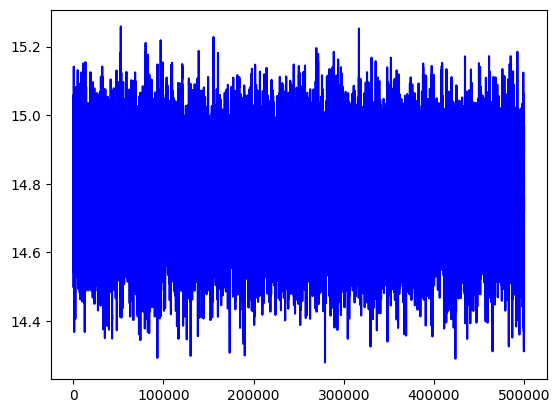

2
1
3
4
5
6
7
8


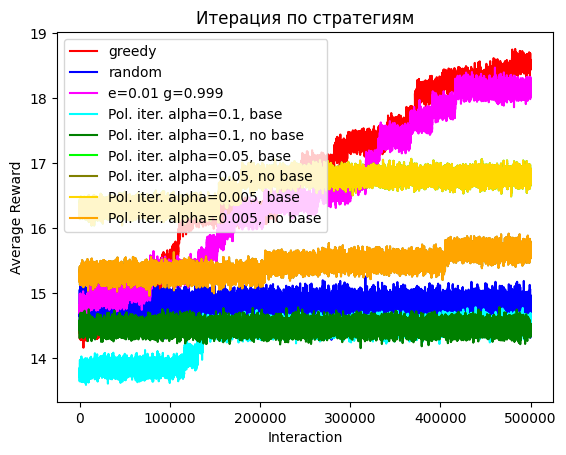

CPU times: user 3h 25min 27s, sys: 7min 17s, total: 3h 32min 45s
Wall time: 3h 25min 36s


In [41]:
%%time
#Итерация по стратегиям
num_arms = 10
num_trials = 100
num_interactions = 500000
bias = 0

rewards_random = run_experiment(num_trials, num_interactions, 1, False)
plt.plot(rollavg_cumsum(rewards_random, 71), label="random", color='blue')
plt.show()
print(2)
rewards_greedy = run_experiment(num_trials, num_interactions, 0, False)
print(1)

rewards_eps_g1_999 = run_experiment_gamma(num_trials, num_interactions, 0.01, 0.999, False)
print(3)
rewards_gradient_01 = run_experiment_policy_iteration(num_trials, num_interactions, 0.1, False, verbose=False,bias=bias)
print(4)
rewards_gradient_01_base = run_experiment_policy_iteration(num_trials, num_interactions, 0.1, True, verbose=False,bias=bias)
print(5)
rewards_gradient_005 = run_experiment_policy_iteration(num_trials, num_interactions, 0.05, False, verbose=False,bias=bias)
print(6)
rewards_gradient_005_base = run_experiment_policy_iteration(num_trials, num_interactions, 0.05, True, verbose=False,bias=bias)
print(7)
rewards_gradient_0005 = run_experiment_policy_iteration(num_trials, num_interactions, 0.005, False, verbose=False,bias=bias)
print(8)
rewards_gradient_0005_base = run_experiment_policy_iteration(num_trials, num_interactions, 0.005, True, verbose=False,bias=bias)


rewards_greedy = run_experiment(num_trials, num_interactions, 0, False)    
plt.plot(rollavg_cumsum(rewards_greedy, 71), label="greedy", color='red')
plt.plot(rollavg_cumsum(rewards_random, 71), label="random", color='blue')
plt.plot(rollavg_cumsum(rewards_eps_g1_999, 71), label="e=0.01 g=0.999", color='magenta')
plt.plot(rollavg_cumsum(rewards_gradient_01_base, 71), label="Pol. iter. alpha=0.1, base", color='cyan')
plt.plot(rollavg_cumsum(rewards_gradient_01, 71), label="Pol. iter. alpha=0.1, no base", color='green')
plt.plot(rollavg_cumsum(rewards_gradient_005_base, 71), label="Pol. iter. alpha=0.05, base", color='lime')
plt.plot(rollavg_cumsum(rewards_gradient_005, 71), label="Pol. iter. alpha=0.05, no base", color='olive')
plt.plot(rollavg_cumsum(rewards_gradient_005_base, 71), label="Pol. iter. alpha=0.005, base", color='gold')
plt.plot(rollavg_cumsum(rewards_gradient_005, 71), label="Pol. iter. alpha=0.005, no base", color='orange')
plt.legend()
plt.xlabel("Interaction")
plt.ylabel("Average Reward")
plt.title(f"Итерация по стратегиям")
plt.show()

In [ ]:
rewards_greedy = run_experiment(num_trials, num_interactions, 0, False)    
plt.plot(rollavg_cumsum(rewards_greedy, 71), label="greedy", color='red')
plt.plot(rollavg_cumsum(rewards_random, 71), label="random", color='blue')
plt.plot(rollavg_cumsum(rewards_eps_g1_999, 71), label="e=0.01 g=0.999", color='magenta')
plt.plot(rollavg_cumsum(rewards_gradient_01_base, 71), label="Pol. iter. alpha=0.1, base", color='cyan')
plt.plot(rollavg_cumsum(rewards_gradient_01, 71), label="Pol. iter. alpha=0.1, no base", color='green')
plt.plot(rollavg_cumsum(rewards_gradient_005_base, 71), label="Pol. iter. alpha=0.05, base", color='lime')
plt.plot(rollavg_cumsum(rewards_gradient_005, 71), label="Pol. iter. alpha=0.05, no base", color='olive')
plt.plot(rollavg_cumsum(rewards_gradient_005_base, 71), label="Pol. iter. alpha=0.005, base", color='gold')
plt.plot(rollavg_cumsum(rewards_gradient_005, 71), label="Pol. iter. alpha=0.005, no base", color='orange')
plt.legend()
plt.xlabel("Interaction")
plt.ylabel("Average Reward")
plt.title(f"Итерация по стратегиям")
plt.show()

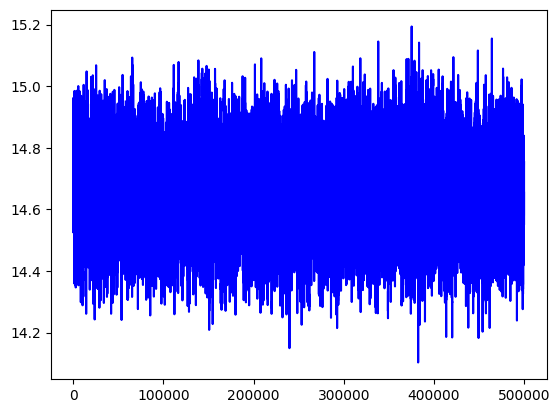

2
1
3
4
5
6
7
8


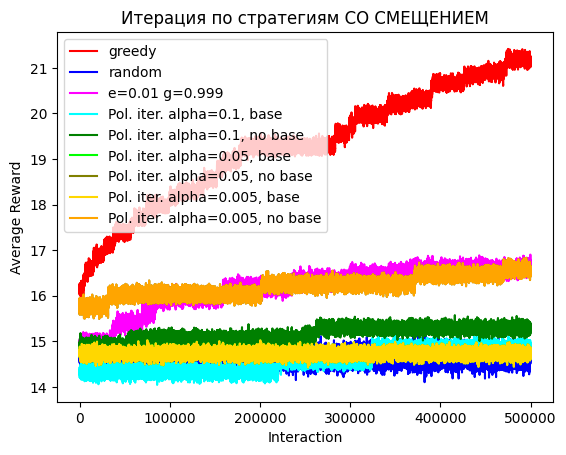

CPU times: user 3h 26min 39s, sys: 7min 23s, total: 3h 34min 2s
Wall time: 3h 33min 33s


In [45]:
%%time
#Итерация по стратегиям СО СМЕЩЕНИЕМ
num_arms = 10
num_trials = 100
num_interactions = 500000
bias=10

rewards_random = run_experiment(num_trials, num_interactions, 1, False)
plt.plot(rollavg_cumsum(rewards_random, 71), label="random", color='blue')
plt.show()
print(2)
rewards_greedy = run_experiment(num_trials, num_interactions, 0, False, bias=bias)
print(1)

rewards_eps_g1_999 = run_experiment_gamma(num_trials, num_interactions, 0.01, 0.999, False,bias=bias)
print(3)
rewards_gradient_01 = run_experiment_policy_iteration(num_trials, num_interactions, 0.1, False, verbose=False,bias=bias)
print(4)
rewards_gradient_01_base = run_experiment_policy_iteration(num_trials, num_interactions, 0.1, True, verbose=False,bias=bias)
print(5)
rewards_gradient_005 = run_experiment_policy_iteration(num_trials, num_interactions, 0.05, False, verbose=False,bias=bias)
print(6)
rewards_gradient_005_base = run_experiment_policy_iteration(num_trials, num_interactions, 0.05, True, verbose=False,bias=bias)
print(7)
rewards_gradient_0005 = run_experiment_policy_iteration(num_trials, num_interactions, 0.005, False, verbose=False,bias=bias)
print(8)
rewards_gradient_0005_base = run_experiment_policy_iteration(num_trials, num_interactions, 0.005, True, verbose=False,bias=bias)


    
plt.plot(rollavg_cumsum(rewards_greedy, 71), label="greedy", color='red')
plt.plot(rollavg_cumsum(rewards_random, 71), label="random", color='blue')
plt.plot(rollavg_cumsum(rewards_eps_g1_999, 71), label="e=0.01 g=0.999", color='magenta')
plt.plot(rollavg_cumsum(rewards_gradient_01_base, 71), label="Pol. iter. alpha=0.1, base", color='cyan')
plt.plot(rollavg_cumsum(rewards_gradient_01, 71), label="Pol. iter. alpha=0.1, no base", color='green')
plt.plot(rollavg_cumsum(rewards_gradient_005_base, 71), label="Pol. iter. alpha=0.05, base", color='lime')
plt.plot(rollavg_cumsum(rewards_gradient_005, 71), label="Pol. iter. alpha=0.05, no base", color='olive')
plt.plot(rollavg_cumsum(rewards_gradient_005_base, 71), label="Pol. iter. alpha=0.005, base", color='gold')
plt.plot(rollavg_cumsum(rewards_gradient_005, 71), label="Pol. iter. alpha=0.005, no base", color='orange')
plt.legend()
plt.xlabel("Interaction")
plt.ylabel("Average Reward")
plt.title(f"Итерация по стратегиям СО СМЕЩЕНИЕМ")
plt.show()